# Classification of pH range using machine learning

In [1]:
HOME_DIR = '/Users/datatranslators/Documents/GitHub/acidoCEST-ML/'
DESTINATION = 'outputs'

## Libraries

In [1]:
#libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn import preprocessing as pp
import seaborn as sns

from sklearn.feature_selection import SelectFromModel

from joblib import dump, load

## Data

In [2]:
# load data
acidoCEST_ML = pd.read_parquet('../clean_data/acido_CEST_MRI_Iopamidol.parquet.gzip')

# drop columns we cannot measure or that are redundant
cols_2_drop = ['ApproT1(sec)','Temp','ExpB0(ppm)','FILE','Conc(mM)']
acidoCEST_ML = acidoCEST_ML.drop(cols_2_drop, axis = 1)

# define experimental columns -- > things we measure other than CEST
exper_cols = [ 'ExpB1(percent)', 'ExpB0(Hz)', 'SatPower(uT)',  'SatTime(ms)','ExpT1(ms)', 'ExpT2(ms)']

# used during development
#acidoCEST_ML  = acidoCEST_ML.sample( n = 5_000)

acidoCEST_ML.shape

(20000, 88)

## Functions

### Random Forest

In [3]:
# Regression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor as RFR

def train_RFR(Xdata, pH_observed):
    print('------------------ Random Forest ------------------ ')
    print()
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, pH_observed, test_size=0.30, random_state=42)
        
        
    
    max_f = int( 0.5 * Xdata.shape[1] )
        
    # Regression
    #param_grid = dict( n_estimators = [100,200,500], max_depth =[None], max_features=['sqrt','log2','auto',max_f], max_samples=[.10,.50], min_samples_leaf=[.01,.50] )

    
    param_grid = dict( n_estimators = [100,200,500], max_depth =[10,40,None] )

    
    # grid parameters
    scorer = metrics.make_scorer( metrics.r2_score, greater_is_better = True) 
    
    #
    estimator = GridSearchCV( RFR(random_state = 42,  n_jobs = -1), param_grid, verbose = 3, cv = 3, n_jobs= 1, scoring=scorer )

    # fit
    estimator.fit(X_train, y_train)

    score_train = np.round( 100 * metrics.mean_absolute_percentage_error(y_train , estimator.predict(X_train)), 2)
    score_test  = np.round( 100 * metrics.mean_absolute_percentage_error(y_test , estimator.predict(X_test)), 2)



    m = f' mean absolute percentage error \n train = {score_train} % \n test  = {score_test} %'
    
    #print(', '.join(Xdata.columns.to_list()))
    print()
    print(m)
   
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_train), y =  y_train)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Train Random Forest')
    
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_test), y =  y_test)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Test Random Forest')
    
    print(estimator.best_estimator_)
    
    return estimator.best_estimator_, estimator

def save_and_print(RFO, name='foo'):
    print('-----')
    for k in RFO.get_params().keys():
        print(f'{k}: {RFO.get_params()[k]}')
    
    dump(RFO, HOME_DIR + DESTINATION + f'/{name}.joblib') 

# Results

## Random Forest

### 4.2 and 5.6 only

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.231 total time=   1.2s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.221 total time=   0.2s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.229 total time=   0.2s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.231 total time=   0.3s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.222 total time=   0.4s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.229 total time=   0.3s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.231 total time=   0.8s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.223 total time=   0.7s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.229 total time=   0.8s
[CV 1/3] END ....max_depth=40, n_estimators=100;, score=0.107 total time=   0.3s
[CV 2/3] END ....max_depth=40, n_estimators=100;, score=0.093 total time=   

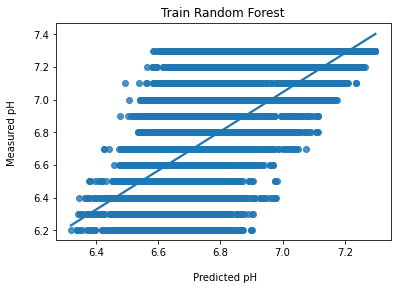

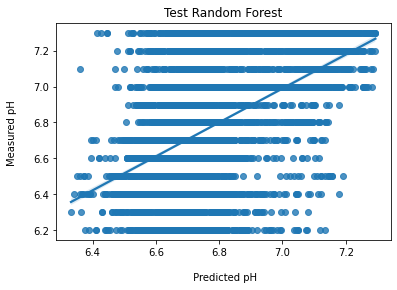

In [5]:
%%time
Xdata = acidoCEST_ML[['4.2','5.6']]
Y = acidoCEST_ML.pH
reg_rf, CVR = train_RFR(Xdata,Y)
save_and_print(reg_rf, name='RF_regressor_4256')

#### Feature Importance

Text(0.5, 1.0, 'Feature Importance for Regression of pH \n Only CEST features were used\n')

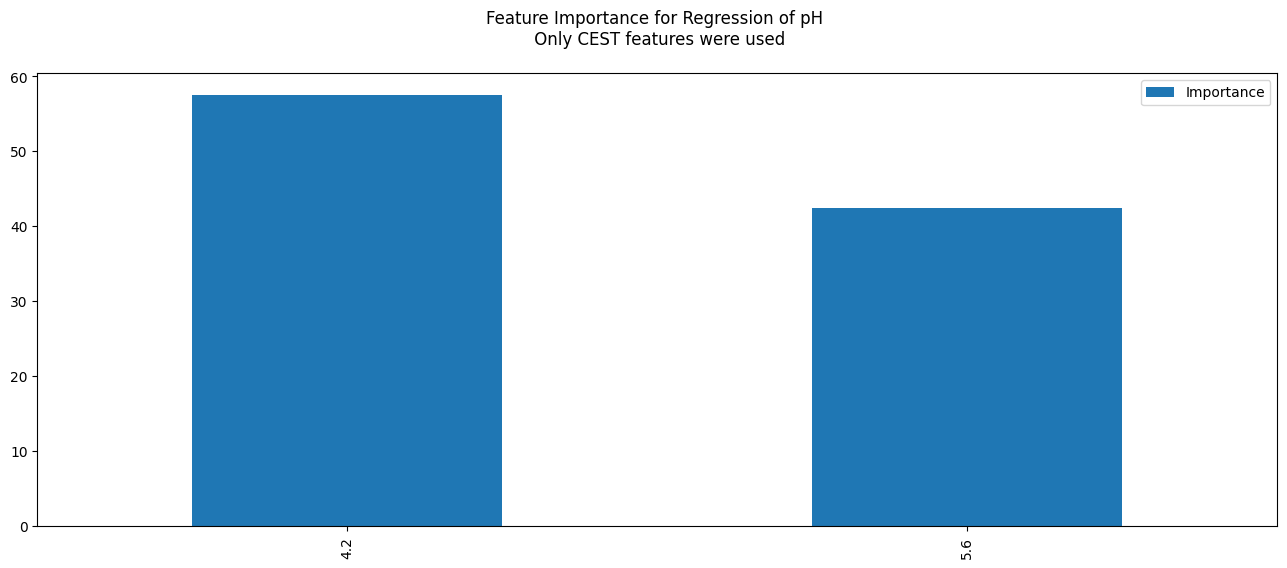

In [6]:
I = pd.DataFrame( 100 * reg_rf.feature_importances_, columns=['Importance'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100, figsize=(16,6))
I.plot(kind='bar', ax = ax, rot=90)
plt.title('Feature Importance for Regression of pH \n Only CEST features were used\n')

### Only CEST data

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.602 total time=   5.0s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.596 total time=   3.3s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.587 total time=   3.3s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.601 total time=   6.8s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.597 total time=   6.7s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.587 total time=   6.8s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.602 total time=  17.6s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.599 total time=  18.0s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.588 total time=  17.9s
[CV 1/3] END ....max_depth=40, n_estimators=100;, score=0.659 total time=   4.9s
[CV 2/3] END ....max_depth=40, n_estimators=100;, score=0.654 total time=   

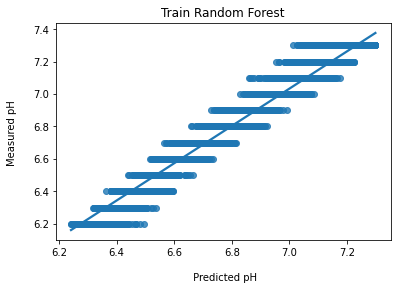

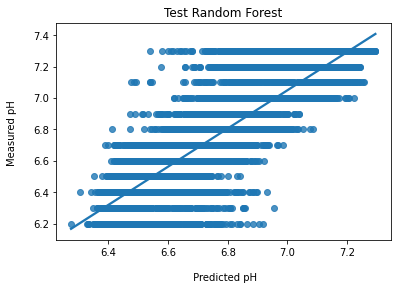

In [7]:
%%time
Xdata = acidoCEST_ML.drop(exper_cols + ['pH'],axis=1)
Ydata = acidoCEST_ML.pH 

reg_rf_only_CEST, CVR = train_RFR(Xdata,Ydata)
save_and_print(reg_rf_only_CEST, name='RF_regressor_all_CEST')

#### Feature Importance

Text(0.5, 1.0, 'Feature Importance for Regression of pH \n Only CEST features were used\n')

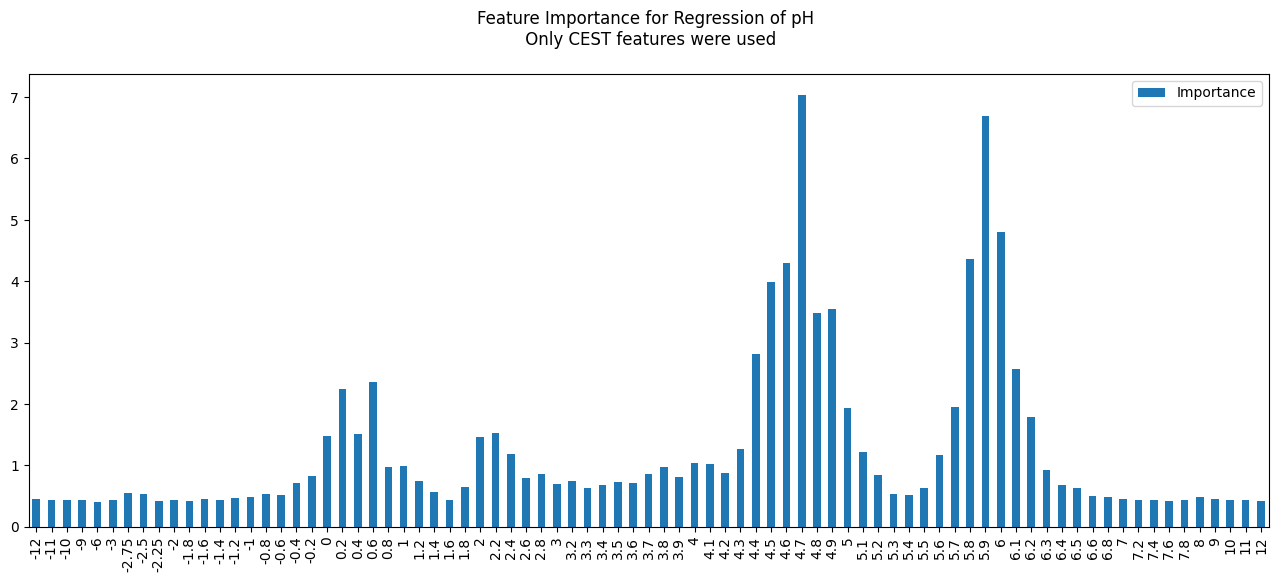

In [8]:
I = pd.DataFrame( 100 * reg_rf_only_CEST.feature_importances_, columns=['Importance'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100, figsize=(16,6))
I.plot(kind='bar', ax = ax, rot=90)
plt.title('Feature Importance for Regression of pH \n Only CEST features were used\n')

### All data

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.730 total time=   3.6s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.746 total time=   3.8s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.743 total time=   4.1s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.737 total time=   7.4s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.749 total time=   7.3s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.743 total time=   7.3s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.734 total time=  18.0s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.748 total time=  17.9s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.748 total time=  17.9s
[CV 1/3] END ....max_depth=40, n_estimators=100;, score=0.909 total time=   5.0s
[CV 2/3] END ....max_depth=40, n_estimators=100;, score=0.919 total time=   

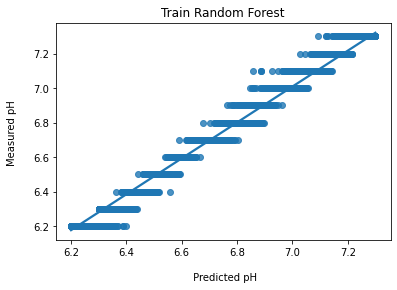

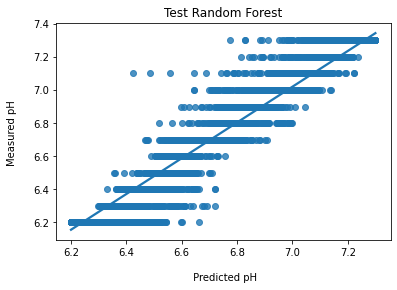

In [9]:
%%time
Xdata = acidoCEST_ML.drop( ['pH'],axis=1) 
Ydata = acidoCEST_ML.pH

reg_rf_all, CV = train_RFR(Xdata,Ydata)
save_and_print(reg_rf_all, name='RF_regressor_all_DATA')

#### Feature Importance

Text(0.5, 1.0, 'Feature Importance for Regression of pH \n All features were used\n')

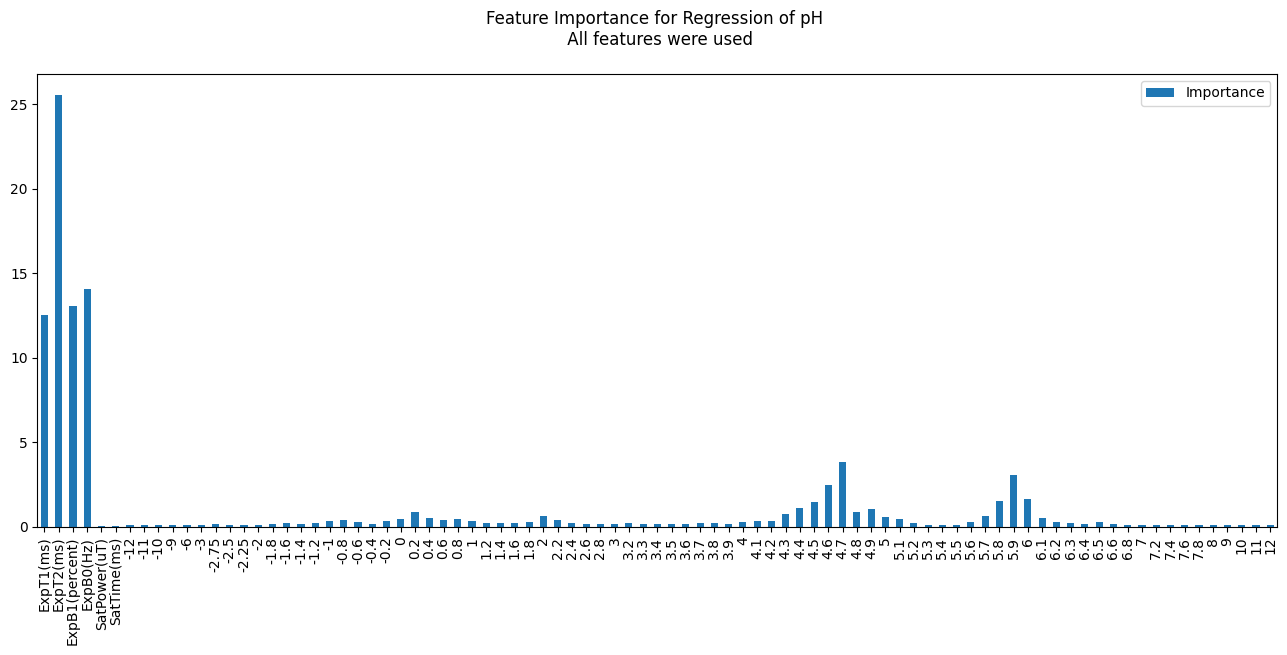

In [10]:
I = pd.DataFrame( 100 * reg_rf_all.feature_importances_, columns=['Importance'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100, figsize=(16,6))
I.plot(kind='bar', ax = ax, rot=90)
plt.title('Feature Importance for Regression of pH \n All features were used\n')

### Recursive Feature elimination

Index(['ExpT1(ms)', 'ExpT2(ms)', 'ExpB1(percent)', 'ExpB0(Hz)', '4.4', '4.5',
       '4.6', '4.7', '5.8', '5.9', '6'],
      dtype='object')
------------------ Random Forest ------------------ 

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.753 total time=   0.5s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.765 total time=   0.5s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.759 total time=   0.5s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.757 total time=   0.9s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.767 total time=   0.9s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.758 total time=   0.9s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.751 total time=   2.3s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.765 total time=   2.4s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.763 total time=   2.3s
[CV 1/3] END ...

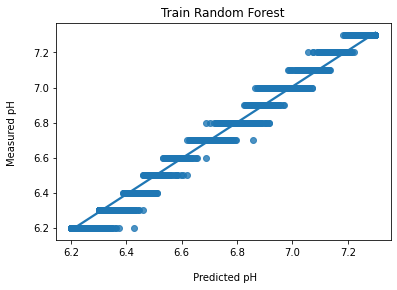

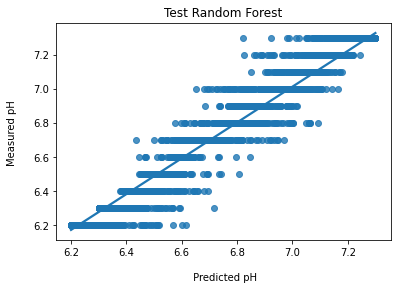

In [11]:
%%time
selected_RF = SelectFromModel( reg_rf_all  , max_features=20) 
selected_RF.fit(Xdata, Ydata)
cols = Xdata.columns[selected_RF.get_support()]
print(cols)

Xdata = acidoCEST_ML[cols]
Ydata = acidoCEST_ML.pH

reg_rf_RFE, CV = train_RFR(Xdata,Ydata)
save_and_print(reg_rf_RFE, name='RF_regressor_selected')

#### Feature Importance

Text(0.5, 1.0, 'Feature Importance for Regression of pH \n All features from recursive elimination were used\n')

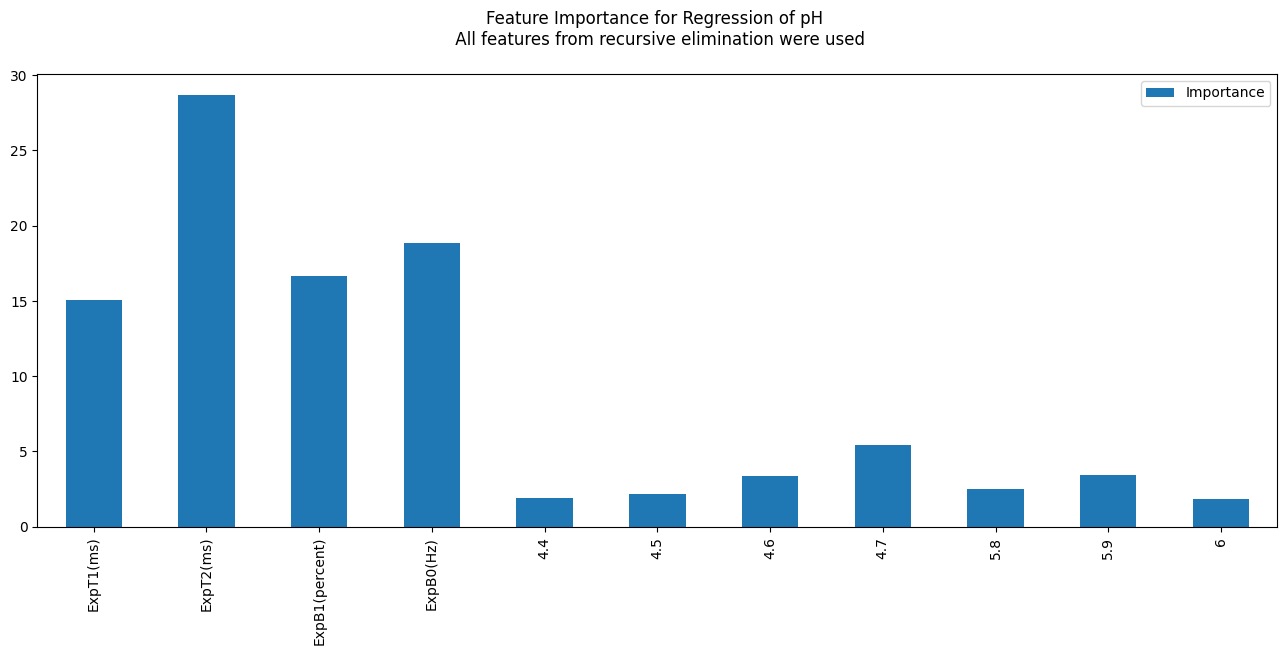

In [12]:
I = pd.DataFrame( 100 * reg_rf_RFE.feature_importances_, columns=['Importance'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100, figsize=(16,6))
I.plot(kind='bar', ax = ax, rot=90)
plt.title('Feature Importance for Regression of pH \n All features from recursive elimination were used\n')

In [11]:
acidoCEST_ML.columns

Index(['pH', 'ExpT1(ms)', 'ExpT2(ms)', 'ExpB1(percent)', 'ExpB0(Hz)',
       'SatPower(uT)', 'SatTime(ms)', '-12', '-11', '-10', '-9', '-6', '-3',
       '-2.75', '-2.5', '-2.25', '-2', '-1.8', '-1.6', '-1.4', '-1.2', '-1',
       '-0.8', '-0.6', '-0.4', '-0.2', '0', '0.2', '0.4', '0.6', '0.8', '1',
       '1.2', '1.4', '1.6', '1.8', '2', '2.2', '2.4', '2.6', '2.8', '3', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.8', '7', '7.2', '7.4', '7.6', '7.8', '8',
       '9', '10', '11', '12'],
      dtype='object')

### Effect of number of  estimators using Recursive Feature elimination features

------------------ Random Forest ------------------ 

RandomForestRegressor(max_depth=32, n_estimators=80, n_jobs=-1, random_state=42)


Text(0, 0.5, 'Mean R2 score \n')

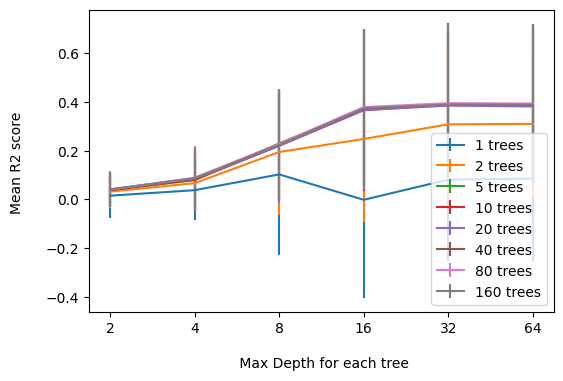

In [13]:
def train_RFR_02(Xdata, pH_observed):
    print('------------------ Random Forest ------------------ ')
    print()
    # grid
    param_grid = dict( n_estimators = [1,2,5,10,20,40,80,160], max_depth = [2**(x) for x in [1,2,3,4,5,6]])

    
    # grid parameters
    scorer = metrics.make_scorer( metrics.r2_score, greater_is_better = True) 
    
    #
    estimator = GridSearchCV( RFR(random_state = 42,  n_jobs = -1), param_grid, verbose = 0, cv = 10, n_jobs= 1, scoring=scorer )

    # fit
    estimator.fit(Xdata, pH_observed)

    score_train = np.round( 100 * metrics.mean_absolute_percentage_error(pH_observed , estimator.predict(Xdata)), 2)
    score_test  = np.round( 100 * metrics.mean_absolute_percentage_error(pH_observed , estimator.predict(Xdata)), 2)



    m = f' mean absolute percentage error \n train = {score_train} % \n test  = {score_test} %'
    
    print(estimator.best_estimator_)
    
    return estimator.best_estimator_, estimator

reg, CV = train_RFR_02(Xdata, Ydata)

R = pd.DataFrame()

pars = ['param_max_depth', 'param_n_estimators','std_test_score','mean_test_score']

for p in pars:
    R[p] = CV.cv_results_[p]

R['param_max_depth'] = R['param_max_depth'].astype(str) 
    
plt.figure(dpi=100)

for n  in R.param_n_estimators.unique():
    scores = R[R.param_n_estimators == n]
    plt.errorbar(x=scores['param_max_depth'], y=scores['mean_test_score'], yerr=scores['std_test_score'])
    
plt.legend([f'{x} trees' for x in R.param_n_estimators.unique()])

plt.xlabel('\n Max Depth for each tree')

plt.ylabel('Mean R2 score \n')

## Matrix Regression

In [236]:
# Regression

def train_RFR_without_split(Xdata, pH_observed):
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, pH_observed, test_size=0.30, random_state=42)
        
    # grid parameters
    #param_grid = dict( n_estimators = [10], max_depth =[10,40,None] )
    
    #score
    #scorer = metrics.make_scorer( metrics.r2_score, greater_is_better = True) 
    
    # fit
    #estimator = GridSearchCV( RFR(random_state = 42,  n_jobs = -1), param_grid, verbose = 0, cv = 3, n_jobs= 1, scoring=scorer )
    #estimator.fit(X_train, y_train)

    
    REG = RFR(random_state = 42,  n_jobs = -1, n_estimators=500, max_depth=None).fit(X_train, y_train)
    
    #REG = estimator.best_estimator_
        
        
    train_e = np.round( 100 * metrics.mean_absolute_percentage_error(y_train, REG.predict(X_train)),2 )
    
    test_e  = np.round( 100 * metrics.mean_absolute_percentage_error(y_test, REG.predict(X_test)),2 )
    return train_e, test_e

def matrix(FEATURES):
    powers = acidoCEST_ML['SatPower(uT)'].unique()
    times = acidoCEST_ML['SatTime(ms)'].unique()
    
    train_results = []
    test_results = []
    
    for p in powers:
        for s in times:
            filt = (acidoCEST_ML['SatPower(uT)'] == p) & (acidoCEST_ML['SatTime(ms)']  == s)
            e1, e2 = train_RFR_without_split(acidoCEST_ML[FEATURES][filt], acidoCEST_ML['pH'][filt])
            train_results.append((p,s,e1))
            test_results.append((p,s,e2))
    
    M_train = pd.DataFrame(train_results,columns=['Sat Power (uT)','Sat Time (ms)','Error']).pivot(index='Sat Power (uT)', columns='Sat Time (ms)', values='Error') 
    M_test = pd.DataFrame(test_results,columns=['Sat Power (uT)','Sat Time (ms)','Error']).pivot(index='Sat Power (uT)', columns='Sat Time (ms)', values='Error')
    return M_train, M_test
    

### 4.2 and 5.6

In [237]:
M1_train, M1_test  = matrix(FEATURES = ['4.2','5.6'])

<AxesSubplot:xlabel='Sat Time (ms)', ylabel='Sat Power (uT)'>

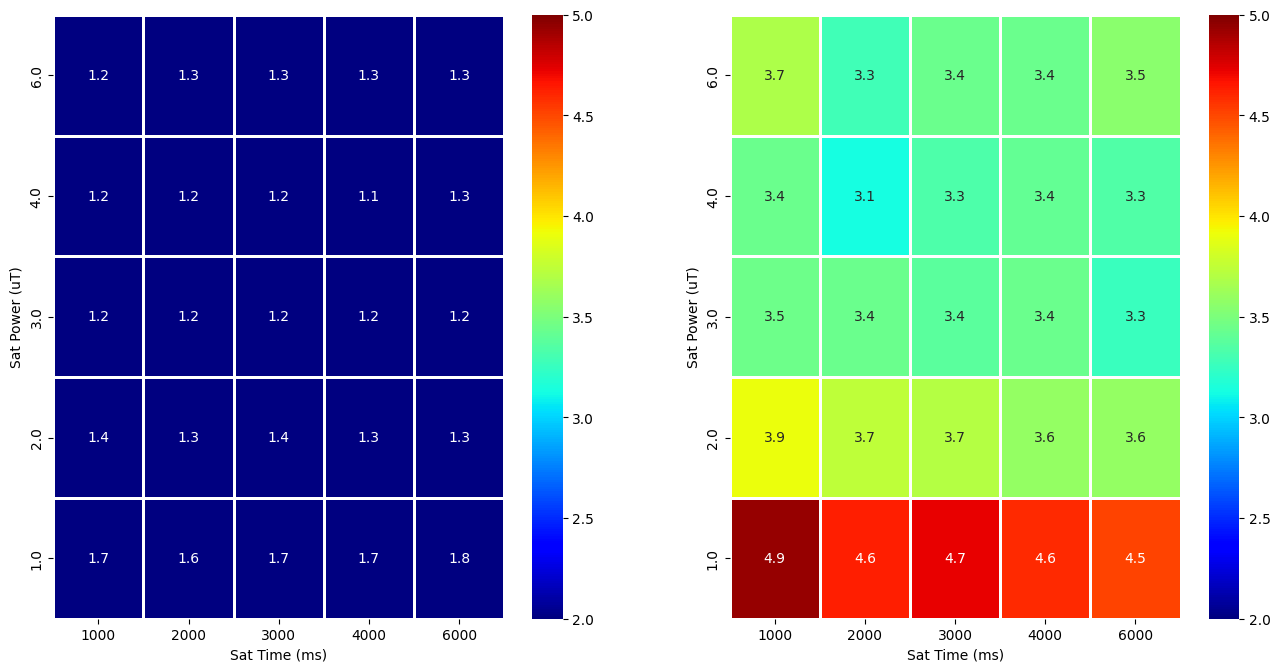

In [238]:
_ , axs = plt.subplots(dpi=100,ncols=2, figsize=(16,8) )
sns.heatmap( M1_train.sort_values('Sat Power (uT)',ascending=False) ,linewidths=1, annot=True, vmin= 2, vmax= 5.0,ax =axs[0], cmap='jet')
sns.heatmap( M1_test.sort_values('Sat Power (uT)',ascending=False) ,linewidths=1, annot=True, vmin= 2, vmax= 5.0,ax =axs[1], cmap='jet')
#plt.title('Mean absolute error (%) for regression of pH \n 4.2 and 5.6 ppm ')

### All CEST

In [239]:
M2_train, M2_test = matrix(FEATURES = acidoCEST_ML.columns[7::] )

<AxesSubplot:xlabel='Sat Time (ms)', ylabel='Sat Power (uT)'>

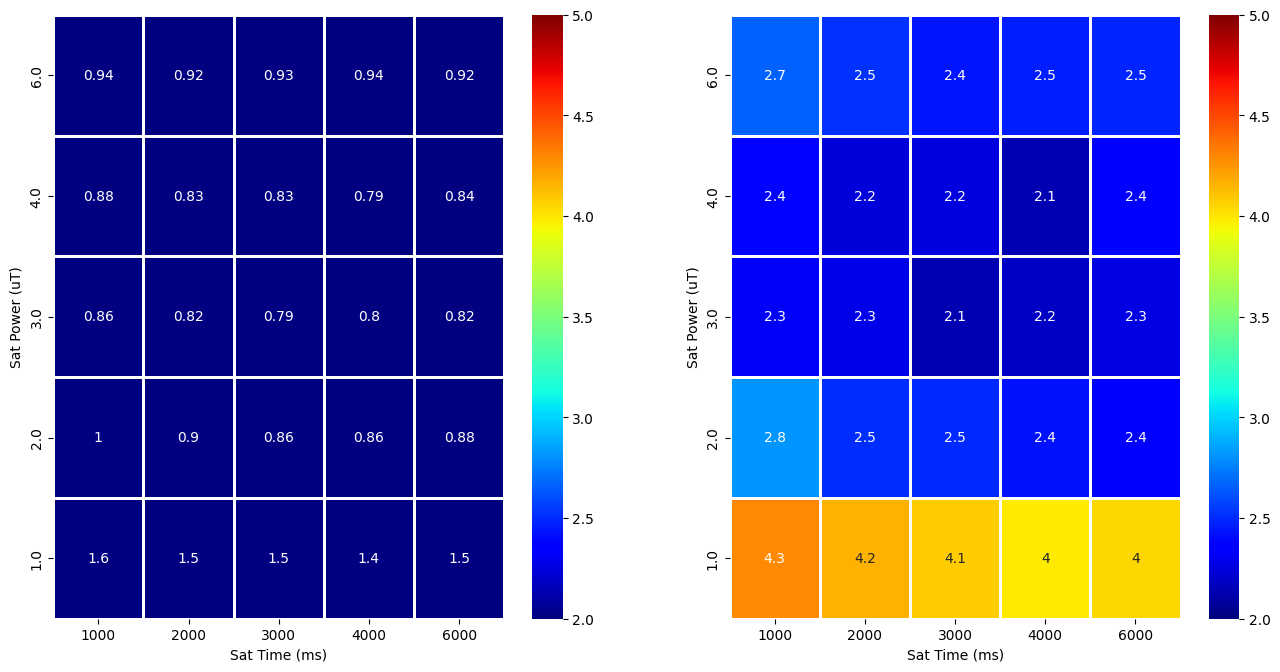

In [240]:
_ , axs = plt.subplots(dpi=100,ncols=2, figsize=(16,8) )
sns.heatmap( M2_train.sort_values('Sat Power (uT)',ascending=False) ,linewidths=1, annot=True, vmin= 2, vmax= 5.0,ax =axs[0], cmap='jet')
sns.heatmap( M2_test.sort_values('Sat Power (uT)',ascending=False) ,linewidths=1, annot=True, vmin= 2, vmax= 5.0,ax =axs[1], cmap='jet')
#plt.title('Mean absolute error (%) for regression of pH \n 4.2 and 5.6 ppm ')

### All data

In [241]:
all_features = list(acidoCEST_ML.drop(['pH'],axis=1).columns)
M3_train, M3_test = matrix(FEATURES = all_features )

<AxesSubplot:xlabel='Sat Time (ms)', ylabel='Sat Power (uT)'>

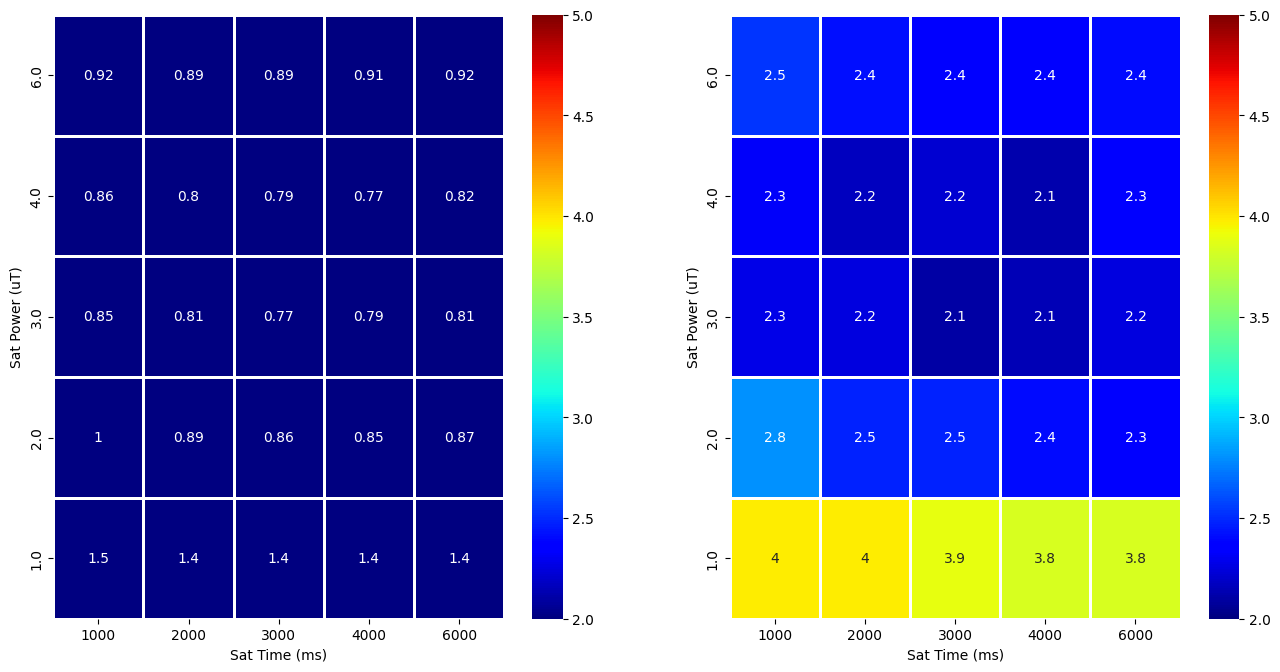

In [242]:
_ , axs = plt.subplots(dpi=100,ncols=2, figsize=(16,8) )
sns.heatmap( M3_train.sort_values('Sat Power (uT)',ascending=False) ,linewidths=1, annot=True, vmin= 2, vmax= 5.0,ax =axs[0], cmap='jet')
sns.heatmap( M3_test.sort_values('Sat Power (uT)',ascending=False) ,linewidths=1, annot=True, vmin= 2, vmax= 5.0,ax =axs[1], cmap='jet')
# plt.title('Mean absolute error (%) for regression of pH \n All features')

### Applying model outside the ranges of Sat power and Sat time used for training

<AxesSubplot:xlabel='Sat Time (ms)', ylabel='Sat Power (uT)'>

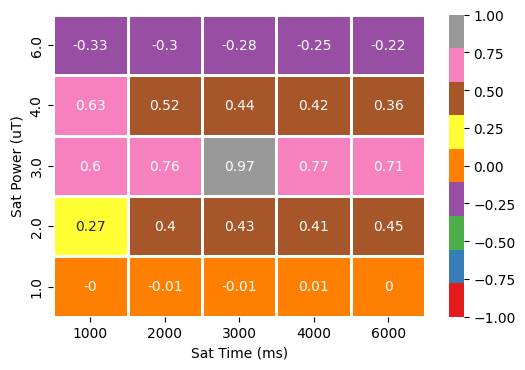

In [304]:
cest_cols = list(acidoCEST_ML.columns[7::])
power = 3.0
time =  3000

filt = (acidoCEST_ML['SatPower(uT)'] == 3.0) & (acidoCEST_ML['SatTime(ms)'] == 3000)
REG = RFR(random_state = 42,  n_jobs = -1, n_estimators=500, max_depth=None).fit(acidoCEST_ML[filt][cest_cols], acidoCEST_ML.pH[filt])

powers = acidoCEST_ML['SatPower(uT)'].unique()
times = acidoCEST_ML['SatTime(ms)'].unique()

Q = []
for p in powers:
    for s in times:
        filt   = (acidoCEST_ML['SatPower(uT)'] == p) & (acidoCEST_ML['SatTime(ms)']  == s)
        y_hat  = REG.predict(acidoCEST_ML[filt][cest_cols])
        y_true = acidoCEST_ML[filt]['pH']
        
        e = np.round( metrics.r2_score(y_true, y_hat),2 )
        Q.append((p,s,e))

MQ = pd.DataFrame(Q,columns=['Sat Power (uT)','Sat Time (ms)','r2_score']).pivot(index='Sat Power (uT)', columns='Sat Time (ms)', values='r2_score')   

_, ax = plt.subplots(dpi=100)
sns.heatmap( MQ.sort_values('Sat Power (uT)',ascending=False) ,linewidths=1, annot=True,  cmap='Set1',ax=ax, vmin=-1 , vmax=1)

### Training model and a small sample of all data -- > Applying model to rest of data

In [296]:
cest_cols = list(acidoCEST_ML.columns[7::])
train, test = train_test_split(acidoCEST_ML, test_size=.70)

REG = RFR(random_state = 42,  n_jobs = -1, n_estimators=500, max_depth=None).fit(train[cest_cols], train.pH)

powers = acidoCEST_ML['SatPower(uT)'].unique()
times = acidoCEST_ML['SatTime(ms)'].unique()

Q2 = []
for p in powers:
    for s in times:
        filt   = (test['SatPower(uT)'] == p) & (test['SatTime(ms)']  == s)
        y_hat  = REG.predict(test[filt][cest_cols])
        y_true = test[filt]['pH']
        
        e = np.round( metrics.r2_score(y_true, y_hat),2 )
        Q2.append((p,s,e))

MQ2 = pd.DataFrame(Q2,columns=['Sat Power (uT)','Sat Time (ms)','r2_score']).pivot(index='Sat Power (uT)', columns='Sat Time (ms)', values='r2_score')   

In [ ]:
_, ax = plt.subplots(dpi=100)
sns.heatmap( MQ2.sort_values('Sat Power (uT)',ascending=False) ,linewidths=1, annot=True,  cmap='Set1',ax=ax, vmin=-1 , vmax=1)
plt.title('R2 score for pH regression \n The model was trained with 30% of all data \n and applied to the rest of the data')

Text(0.5, 1.0, 'R2 score for pH regression \n The model was trained with 30% of all data \n and applied to the rest of the data')